In [1]:
!pip install tensorflow opencv-python matplotlib

In [25]:
# importing necessary libraries and components
import tensorflow as tf
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

(439, 712, 3)


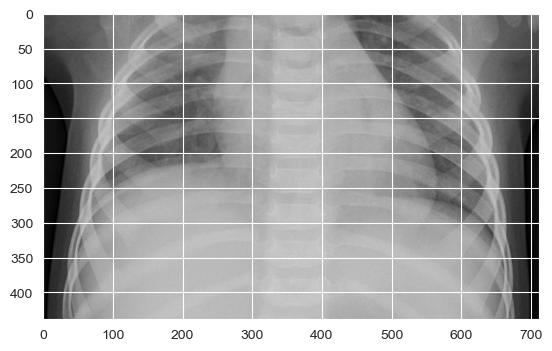

In [26]:
# testing image
image = cv2.imread(os.path.join('data', 'PNEUMONIA', 'person1_bacteria_1.jpeg'))
print(image.shape)
plt.imshow(image)
plt.show()

In [4]:
# LOADING DATA ---------------------------------
data = tf.keras.utils.image_dataset_from_directory('data') #creates data pipeline and labels the data
data_iterator = data.as_numpy_iterator() #converts data to numpy arrays for access
batch = data_iterator.next() #allows access to data pipeline

Found 5856 files belonging to 2 classes.


2 (32, 256, 256, 3)
[1 1 1 0 1 1 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 0]


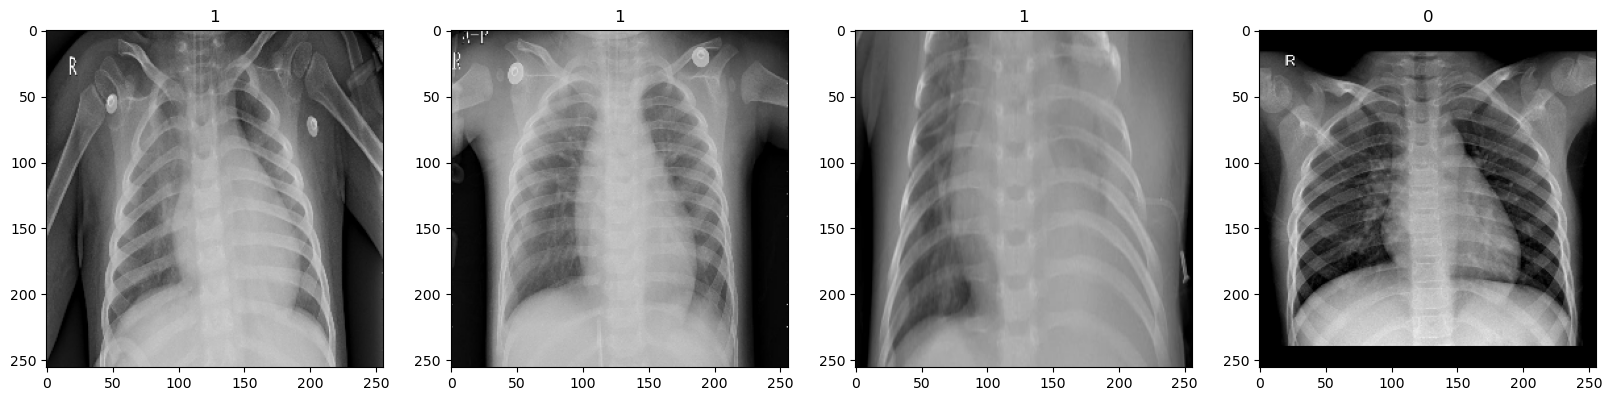

In [5]:
print(len(batch), batch[0].shape)
print(batch[1])
fig, axs = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(batch[0][:4]):
    axs[idx].imshow(image.astype(int))
    axs[idx].title.set_text(batch[1][idx]) 
plt.show()

In [6]:
#0 is assigned to normal and 1 is assigned to pneumonia

In [7]:
# PREPROCESSING DATA -----------------------------------
training_size = int(len(data)*0.7) #calcualting data size for training (70%)
validation_size = int(len(data)*0.2)+1 #calculating data size for validation (20%)
testing_size = len(data)-training_size-validation_size #calculating data size for testing (10%)

print(training_size) #128
print(validation_size) #36+1
print(testing_size) #18

# making sure all batches included = 183

128
37
18


In [8]:
print(len(data))

183


In [9]:
train_data = data.take(training_size) #allocating batches for training based on above calculated batch size
remaining_data = data.skip(training_size) 
validation_data = remaining_data.take(validation_size) #allocating batches for validation
test_data = remaining_data.skip(validation_size) #allocating batches for test

In [10]:
train = train_data.map(lambda x, y: (x/255, y))
validation = validation_data.map(lambda x, y: (x/255, y))
test = test_data.map(lambda x, y: (x/255, y))

#applying normalization to bring pixel values from 0-255 to between 0-1 

In [ ]:
pneumonia_train_count = 0
normal_train_count = 0
for images, labels in train:
    pneumonia_train_count += sum(labels.numpy()) #since label 1 is assigned to pneumonia
    normal_train_count += len(labels)-sum(labels.numpy())

print(f'Number of PNEUMONIA images in training set: {pneumonia_train_count}')
print(f'Number of NORMAL images in training set: {normal_train_count}')

#calculating for data visualization step

Number of PNEUMONIA images in training set: 2984
Number of NORMAL images in training set: 1112


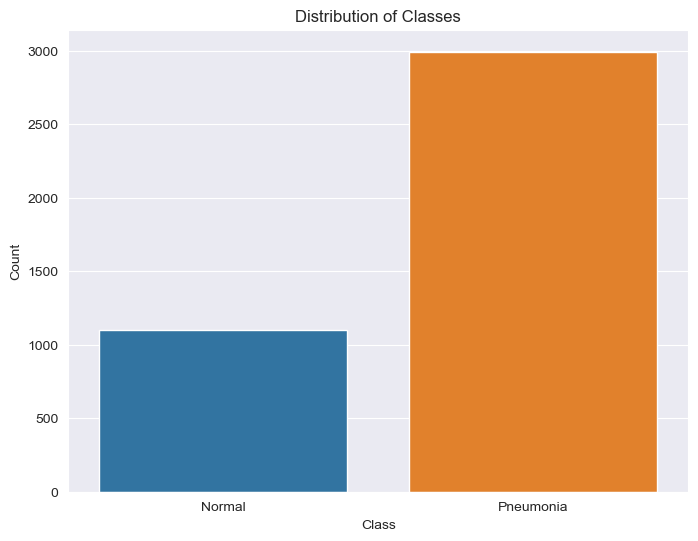

In [13]:
# DATA VISUALIZATION ---------------------
class_names = ['Normal', 'Pneumonia']  
label_counts = {class_name: 0 for class_name in class_names}
for batch in train:
    labels = batch[1]  
    for label in labels:
        class_name = class_names[label]
        label_counts[class_name] += 1

sns.set_style('darkgrid')
plt.figure(figsize=(8, 6))
sns.barplot(x=list(label_counts.keys()), y=list(label_counts.values()))
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [14]:
#assigning class weights due to class imbalance
total_pneumonia_samples = 4273
total_normal_samples = 1583

class_weight = {
    0: (1/total_normal_samples)*(total_normal_samples+total_pneumonia_samples)/2.0,
    1: (1/total_pneumonia_samples)*(total_normal_samples+total_pneumonia_samples)/2.0
}

In [41]:
# BUILDING DEEP LEARNING MODEL -----------------------------------
model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3))) #performs convulational operations with relu activation
model.add(tf.keras.layers.MaxPooling2D()) #reducing spatial dimensions of data

model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())

model.add(tf.keras.layers.Flatten()) #tranforms output from conv layers into 1D array so it can be inputted to dense layers
model.add(tf.keras.layers.Dense(256, activation='relu')) #fully connected layer with 256 nuerons
model.add(tf.keras.layers.Dropout(0.5)) #to prevent overfitting; drops out 50% nuerons during training
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) #final layer with 1 nueron and sigmoid activation to provide output between 0-1 for binary classification

opt = tf.keras.optimizers.Adam(learning_rate=0.001) #using adam optimizer with LR of 0.001

log_directory = 'log'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_directory) #configured callback to enable visualization during training

model.compile(optimizer=opt, loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy']) #binary cross entropy function used for binary classification

In [42]:
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

In [43]:
def scheduler(epoch, lr):
    if epoch<5:
        return lr #for first 5 epochs, maintain 0.001 LR
    else:
        return lr*tf.math.exp(-0.1) #after 5th epoch, LR exponentially decays by a small amount

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train, epochs=10, validation_data=validation, class_weight=class_weight, callbacks=[tensorboard_callback, lr_scheduler]) #training model 

Epoch 1/10
128/128 [==============================] - 61s 457ms/step - loss: 0.3593 - accuracy: 0.8262 - val_loss: 0.2811 - val_accuracy: 0.8944 - lr: 0.0010
Epoch 2/10
128/128 [==============================] - 56s 436ms/step - loss: 0.1896 - accuracy: 0.9309 - val_loss: 0.1771 - val_accuracy: 0.9341 - lr: 0.0010
Epoch 3/10
128/128 [==============================] - 58s 450ms/step - loss: 0.1593 - accuracy: 0.9407 - val_loss: 0.1737 - val_accuracy: 0.9350 - lr: 0.0010
Epoch 4/10
128/128 [==============================] - 57s 443ms/step - loss: 0.1308 - accuracy: 0.9512 - val_loss: 0.1218 - val_accuracy: 0.9535 - lr: 0.0010
Epoch 5/10
128/128 [==============================] - 58s 447ms/step - loss: 0.1127 - accuracy: 0.9597 - val_loss: 0.1893 - val_accuracy: 0.9307 - lr: 0.0010
Epoch 6/10
128/128 [==============================] - 58s 448ms/step - loss: 0.0958 - accuracy: 0.9668 - val_loss: 0.1045 - val_accuracy: 0.9569 - lr: 9.0484e-04
Epoch 7/10
128/128 [============================

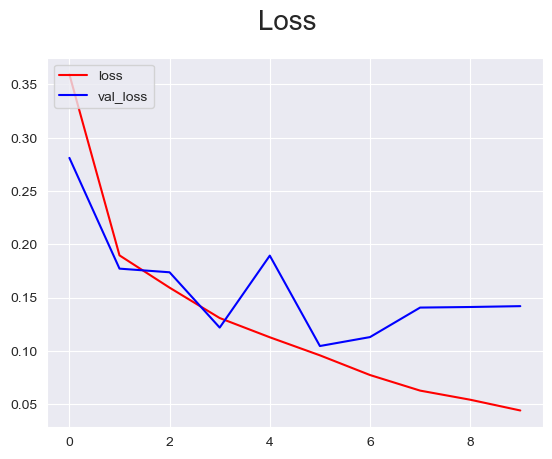

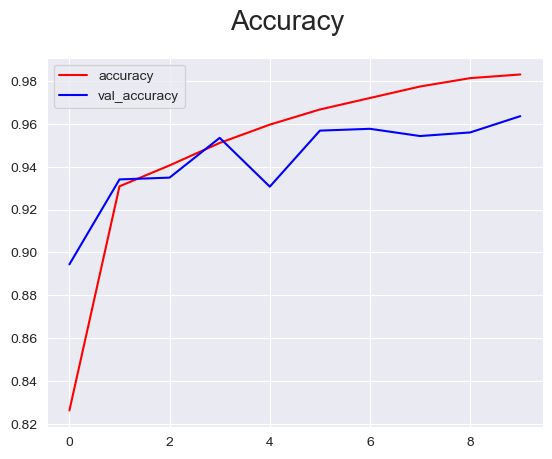

In [44]:
# PLOTTING ACCURACY AND OTHER METRICS --------------------------------------    
fig = plt.figure()
plt.plot(history.history['loss'], color='red', label='loss')
plt.plot(history.history['val_loss'], color='blue', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['accuracy'], color='red', label='accuracy')
plt.plot(history.history['val_accuracy'], color='blue', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [45]:
#Model evaluation
precision = tf.keras.metrics.Precision()
recall = tf.keras.metrics.Recall()
accuracy = tf.keras.metrics.BinaryAccuracy()

y_true = [] #for true label collection
y_pred =[] #for model prediction collection

for batch in test.as_numpy_iterator():
    X, y = batch
    y_ = model.predict(X) #using model for prediction on data X
    #updating metrics after comparing true y value and predicted y value
    precision.update_state(y, y_) 
    recall.update_state(y, y_)
    accuracy.update_state(y, y_)
    
    y_true.extend(y)
    y_pred.extend(y_)

1/1 [==============================] - 0s 93ms/step


In [46]:
print(type(y_true))
print(type(y_pred))

print(y_true[:10])
print(y_pred[:10]) 

<class 'list'>
<class 'list'>
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1]
[array([0.99999714], dtype=float32), array([0.9999856], dtype=float32), array([0.999863], dtype=float32), array([0.9998016], dtype=float32), array([0.8723631], dtype=float32), array([0.0081538], dtype=float32), array([0.8389559], dtype=float32), array([1.], dtype=float32), array([0.99552125], dtype=float32), array([0.99991506], dtype=float32)]


In [47]:
# RESULTS -------------------------
print(f'Precision: {precision.result().numpy()*100}') #true Positives/(true positives+false positives)
print(f'Recall: {recall.result().numpy()*100}') #true Positives/(true positives+false negatives)
print(f'Accuracy: {accuracy.result().numpy()*100}') #correct predictions/total predictions

Precision: 96.23529314994812
Recall: 96.69030904769897
Accuracy: 94.79166865348816


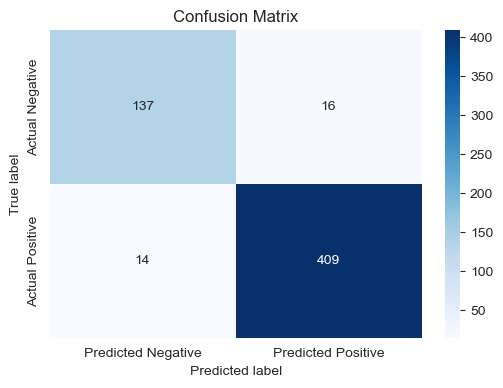

In [48]:
# CONFUSION MATRIX -----------------------
threshold=0.5
y_pred_binary = [1 if pred[0]>=threshold else 0 for pred in y_pred] #converting decimal values to 0s and 1s
cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [49]:
#SAVING MODEL -----------------------------------
model.save('models/chestxrayclassifier.keras')

In [51]:
#EVALUATING MODEL ----------------
loaded_model = tf.keras.models.load_model('models/chestxrayclassifier.keras')
metrics = loaded_model.evaluate(test)

print("Test loss:", metrics[0])
print("Test Accuracy:", metrics[1])

18/18 [==============================] - 12s 102ms/step - loss: 0.2046 - accuracy: 0.9462
Test loss: 0.20462340116500854
Test Accuracy: 0.9461805820465088


In [52]:
#Taking input image for evaluation 
test_image = cv2.imread(r'data\NORMAL\IM-0021-0001.jpeg')
resized_image = cv2.resize(test_image, (256, 256))  
normalized_image = resized_image/255.0  
final_test_image = np.expand_dims(normalized_image, axis=0)  

prediction = loaded_model.predict(final_test_image)
if prediction>0.5:
    print("Predicted as PNEUMONIA.")
else:
    print("Predicted as NORMAL.")

1/1 [==============================] - 0s 144ms/step
Predicted as NORMAL.
